### About Competition

This competition is based on automatically localizing and classifying 14 types of thoracic abnormalities from chest radiographs. The dataset consists of 18,000 scans that have been annotated by experienced radiologists. The model needs to be trained on 15,000 independently-labeled images and will be evaluated on a test set of 3,000 images. These annotations were collected via VinBigData's web-based platform, VinLab.

If successful, it can be used as a valuable second opinion for radiologists. An automated system that could accurately identify and localize findings on chest radiographs would relieve the stress of busy doctors while also providing patients with a more accurate diagnosis.

In [7]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
import os
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.patches as patches
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')

### Understanding the dataset

In [2]:
df = pd.read_csv('train.csv')
print('shape of dataframe:', df.shape)
df.head(5)

shape of dataframe: (67914, 8)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [452]:
df.nunique().to_frame().rename(columns={0:"Unique Values"}).style.background_gradient(cmap="Purples")

,Unique Values
image_id,15000
class_name,15
class_id,15
rad_id,17
x_min,2521
y_min,2570
x_max,2644
y_max,2714


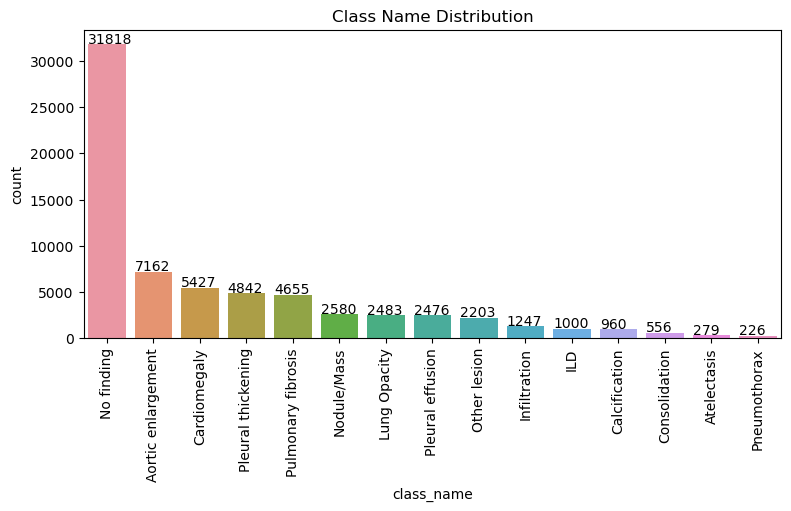

In [437]:
plt.figure(figsize=(9,4))
sns.countplot(df.class_name, order = df.class_name.value_counts().index)
plt.xticks(rotation=90)

for j, item in enumerate(df.class_name.value_counts()):
    plt.annotate(item, xy=(j-0.4, item+100), rotation=0)

plt.title('Class Name Distribution')
plt.show()

In [451]:
# Check empty bounding box for observations other than No finding
filt = df.class_name!='No finding'
df[filt].isna().sum().to_frame().rename(columns={0:"Nan_counts"}).style.background_gradient(cmap="Purples")

,Nan_counts
image_id,0
class_name,0
class_id,0
rad_id,0
x_min,0
y_min,0
x_max,0
y_max,0


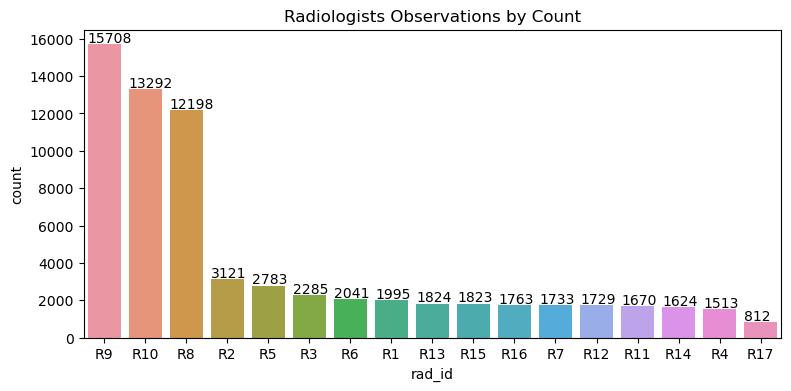

In [430]:
plt.figure(figsize=(9,4))
plot = sns.countplot(df.rad_id, order= df.rad_id.value_counts().index)

for j, item in enumerate(df.rad_id.value_counts()):
    plot.annotate(item, xy=(j-0.4, item+100), rotation=0)

plt.title('Radiologists Observations by Count')
plt.show()

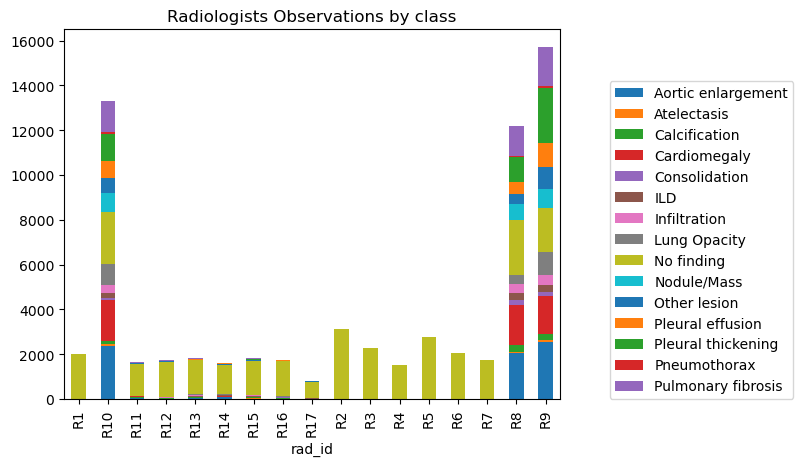

In [435]:
dfPivot = df.groupby(['class_name', 'rad_id']).size().reset_index().pivot(columns='class_name', index='rad_id', values=0)
dfPivot.plot(kind='bar', stacked=True)

plt.legend(loc=[1.1,0])
plt.title('Radiologists Observations by class')
plt.show()

In [397]:
noFindingdf = pd.DataFrame(columns=['Radiologist', '% No Finding Observations', '% match with R8'])

Radiologists = df.rad_id.unique()
for item in Radiologists:
    # Taking R8 as a reference, find out how many No findings from R9 match with these Radiologists
    commons = df[(df.class_name == 'No finding') & ((df.rad_id==item)|(df.rad_id=='R8'))]
    
    count = 0
    for val in commons.image_id.value_counts():
        if val == 2:
            count += 1

    noFindingMatchWithR8 = count*100/len(df.class_name[df.rad_id==item])
    percentNoFinding = df.class_name[df.rad_id==item].value_counts()[0]*100/len(df.class_name[df.rad_id==item])
    
    noFindingdf = noFindingdf.append({'Radiologist':item, '% No Finding Observations': round(percentNoFinding,2),
                                      '% match with R8': round(noFindingMatchWithR8,2)}, ignore_index = True)

noFindingdf.sort_values(by='% No Finding Observations', ascending= False)

,Radiologist,% No Finding Observations,% match with R8
8,R5,100.00,7.83
12,R1,100.00,6.47
5,R3,100.00,7.88
7,R6,100.00,7.89
1,R7,100.00,8.02
9,R4,100.00,6.94
10,R2,99.90,7.66
4,R17,91.50,4.80
15,R12,91.38,4.05
11,R16,88.77,4.14


* Here we can see, the majority of the observations are made by R8, R9 and R10. Only R9, R8 and R10 have 'no finding' observations less than 80%.
* R1, R2, R4, R4, R5, R6, R7 have ~100% of the time have marked the observation as 'no finding' and approximately 7% of these no finding observations match with R9, R8, R10
* There is a significant label imbalance for 'no finding' observations. R8, R9 and R10 also have label imbalance.

In [394]:
imageIDCounter = Counter(df.image_id)
print(imageIDCounter.most_common(3))
df[df.image_id == imageIDCounter.most_common(3)[2][0]].head(10)

[('03e6ecfa6f6fb33dfeac6ca4f9b459c9', 57), ('fa109c087e46fe1ea27e48ce6d154d2f', 52), ('e31be972e181987a8600a8700c1ebe88', 48)]


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
496,e31be972e181987a8600a8700c1ebe88,Nodule/Mass,8,R10,1959.0,492.0,2030.0,663.0
606,e31be972e181987a8600a8700c1ebe88,Pleural thickening,11,R8,1805.0,1037.0,2114.0,1484.0
1156,e31be972e181987a8600a8700c1ebe88,Pleural thickening,11,R10,1852.0,1967.0,2377.0,2206.0
6460,e31be972e181987a8600a8700c1ebe88,Calcification,2,R10,495.0,1933.0,1090.0,2136.0
7329,e31be972e181987a8600a8700c1ebe88,Lung Opacity,7,R10,2258.0,1708.0,2312.0,1913.0
8481,e31be972e181987a8600a8700c1ebe88,Pleural thickening,11,R9,480.0,1960.0,1171.0,2119.0
8929,e31be972e181987a8600a8700c1ebe88,Lung Opacity,7,R10,615.0,1063.0,902.0,1356.0
10056,e31be972e181987a8600a8700c1ebe88,Calcification,2,R9,585.0,1025.0,910.0,1370.0
10745,e31be972e181987a8600a8700c1ebe88,Pleural thickening,11,R10,495.0,1933.0,1090.0,2136.0
11594,e31be972e181987a8600a8700c1ebe88,Pulmonary fibrosis,13,R10,575.0,1023.0,657.0,1314.0


* There are multiple observations (with bounding box) made by multiple radiologists for multple classes
* There can be upto 57 observations per image

In [269]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


In [548]:
def show_dicom(image_id, root_dir='.\\train'):
    image_path = os.path.join(root_dir, image_id+".dicom")    
    img = read_xray(image_path)
    plt.figure(figsize = (8,8))
    plt.imshow(img, 'gray')

Ref: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way for converting DICOM to numpy array

In [549]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.x_min, row.y_min, row.x_max, row.y_max, row.class_name))  
    return bboxes

def plot_image(image_id, df):
    show_dicom(image_id)
    colorDictionary = {'Nodule/Mass':'red', 'Pleural thickening':'green', 'Calcification':'blue',
       'Lung Opacity':'y', 'Pulmonary fibrosis':'orange', 'Cardiomegaly':'coral','Other lesion':'teal',
       'Aortic enlargement':'magenta', 'Pleural effusion':'lawngreen', 'ILD':'olive', 'Infiltration':'aqua'}
    
    bboxes = get_all_bboxes(df, image_id)
    for i, bbox in enumerate(bboxes): 
        patch = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                    edgecolor=colorDictionary[bbox[4]],linewidth=1, facecolor='none', 
                                  label=bbox[4])
        ax = plt.gca()
        ax.add_patch(patch)
    ax.legend(loc=(1.1,0), ncol=2)

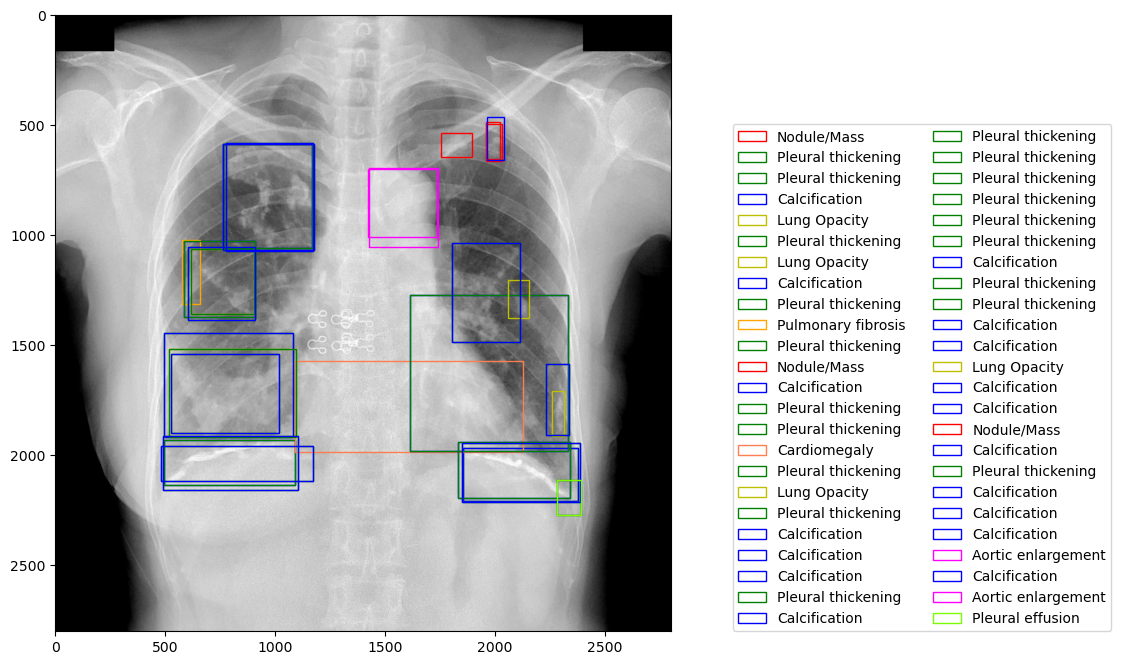

In [550]:
imageId = imageIDCounter.most_common(3)[2][0]
# print(df.class_name[df.image_id == imageIDCounter.most_common(3)[2][0]].value_counts())
df_max = df[df['image_id'] == imageId].copy()
df_max = df_max.reset_index(drop=True)
plot_image(imageId, df_max)

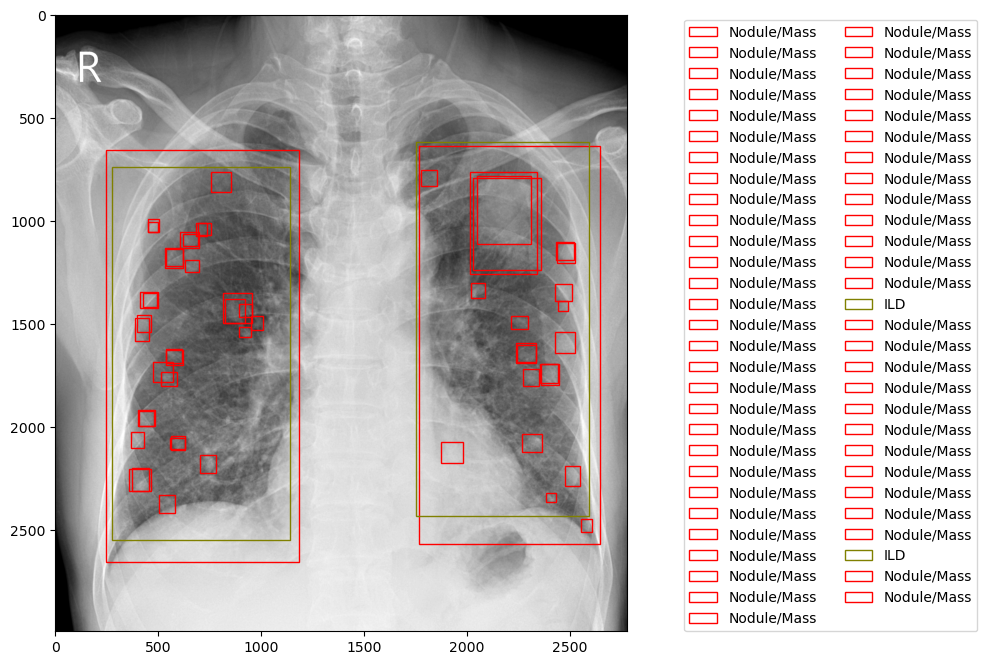

In [551]:
imageId = imageIDCounter.most_common(3)[0][0]
# print(df.class_name[df.image_id == imageIDCounter.most_common(3)[0][0]].value_counts())
df_max = df[df['image_id'] == imageId].copy()
df_max = df_max.reset_index(drop=True)
plot_image(imageId, df_max)

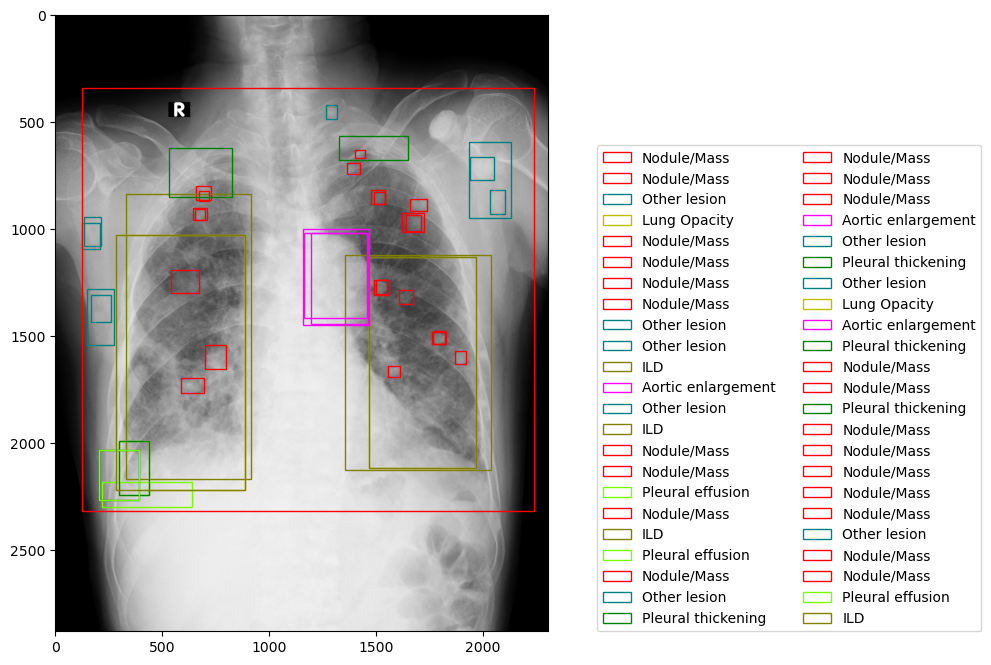

In [552]:
imageId = imageIDCounter.most_common(5)[4][0]
# print(df.class_name[df.image_id == imageIDCounter.most_common(5)[4][0]].value_counts())
df_max = df[df['image_id'] == imageId].copy()
df_max = df_max.reset_index(drop=True)
plot_image(imageId, df_max)

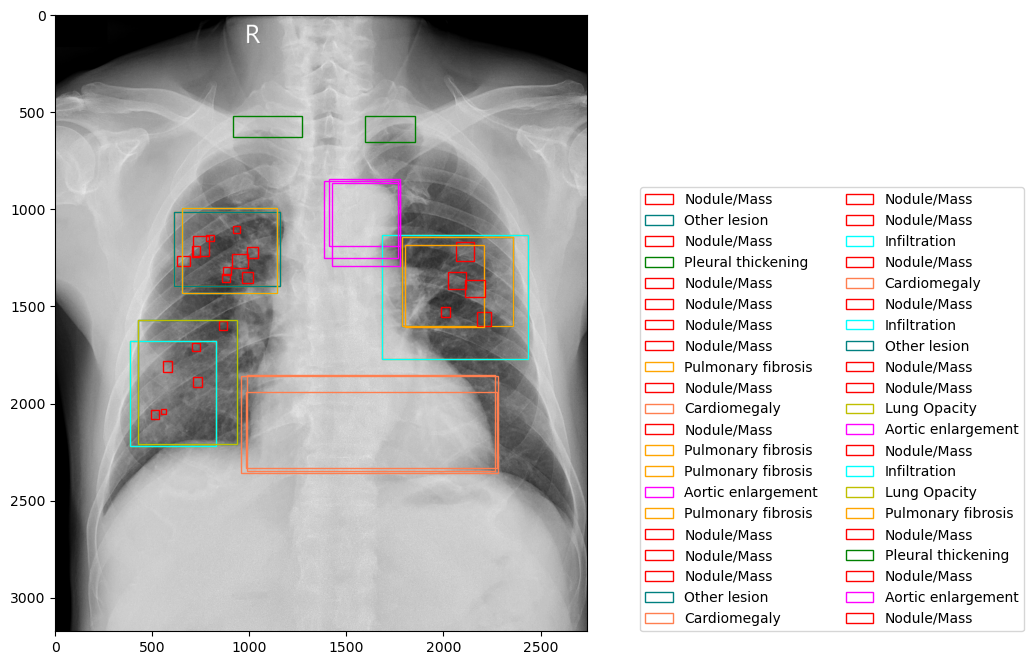

In [553]:
imageId = imageIDCounter.most_common(7)[6][0]
# print(df.class_name[df.image_id == imageIDCounter.most_common(5)[4][0]].value_counts())
df_max = df[df['image_id'] == imageId].copy()
df_max = df_max.reset_index(drop=True)
plot_image(imageId, df_max)

### Conclusions on dataset
* Multilabel classification and object detection problem
* Significant Label imbalance resulting from multiple observers
* Any abnormality can be present anywhere between the abdomen inferiorly and the root of the neck superiorly.